<a href="https://colab.research.google.com/github/deepintomlf/mlfbook/blob/master/PracticeSession2_RRL_ch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction




In the second part of this practice session, we will reformulate the Recurrent Reinforcement Learning (RRL) as the customized neural network model with Recurrent Neural Network(RNN) layer. Following [1] we will apply the RRL algorithm to learn optimal trading strategies on synthetic data.

This session aims to help you 


1.   deepen the understanding of RRL and RNN;
2.   implement the RNN model using Keras;
3.   master how to write the customized neural network in Keras.



## Recurrent Reinforcement Learning(RRL)
Recurrent Reinforcement Learning (RRL) is an adaptive approach of DR to solve the portfolio optimization problem, which can be simple re-interpreted as the RNN model. 

[[1]](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=935097) Moody, J. and Saffell, M., 2001. Learning to trade via direct reinforcement. IEEE transactions on neural Networks, 12(4), pp.875-889.

**Goal**: To learn optimal trading stategy to maximize the Sharpe Ratio over the period.

**Problem setup**:


1.   $z_{t}$ is the price of the asset at time $t$;
2.   $r_{t}$ is the return at time $t$, i.e. $r_{t} = z_{t} - z_{t-1}$;
3.   $r_{t}^{f}$ is the risk-free return at time $t$;
4.   $F_{t}$ is the unit of the asset to trade at time $t$, where
\begin{eqnarray*}
F_{t} = \text{sign}\left({\color{blue}\mu} F_{t-1} + \sum_{ i = 0}^{p-1} {\color{blue}\nu_{i}} r_{t - i} + {\color{blue}\omega}\right),
\end{eqnarray*}
where $F_{t} \in \{ -1, 0, +1\}$, and ${\color{blue}\theta \equiv (\mu,\nu_{0} \cdots, \nu_{m}, \omega)}$ are model parameters
5.   $R_{t}$ is the trading return at time $t$, 
\begin{equation*}
R_{t} \equiv u \{ r_{t}^{f} + F_{t-1}(r_{t} - r_{t}^{f}) - \delta \vert F_{t} - F_{t-1} \vert \}.
\end{equation*}

The goal is to learn the optimal parameters to maximize the objective function (Sharpe Ratio $S_{T}$): 
\begin{eqnarray*}
S_{T} = \frac{\text{Average} (R_{t})}{\text{Standard Deviation} (R_{t})}.
\end{eqnarray*}

 ![alt text](https://docs.google.com/uc?export=download&id=1RuV5C928ow0JnSmlhP9tDp4arAUEbCrY)

## Recurrent Neural Network
1.  Input Layer $(x_{t})_{t = 1}^{T}$: 
2. Hidden Layer $(s_{t})_{t = 1}^{T}$:
\begin{eqnarray*}
s_{t} = h({\color{blue}U}x_{t} + {\color{blue}W}s_{t-1}).
\end{eqnarray*}
3. Output Layer $(o_{t})_{t = 1}^{T}$:
\begin{eqnarray*}
o_{t} = g({\color{blue}V}s_{t})，
\end{eqnarray*}
where ${\color{blue}\theta } \equiv (U, W, V) $ are RNN parameters to learn from data.

 ![alt text](https://docs.google.com/uc?export=download&id=1TdW2XhSyK0o7shHV_nh2ywt9gS142Fra)

#人工模拟数据



We generate log price series $(p(t))_{t = 1}^{T}$ based on the following models:
\begin{eqnarray}
p(t) &=& p(t-1) + \beta(t-1) + k \varepsilon(t),\\
\beta(t)& =&\alpha \beta(t-1) + \epsilon(t),
\end{eqnarray}
where $\alpha = 0.9$ and $k =3$, $(\varepsilon(t),\epsilon(t))$ is a two dimensional standard normal distributed variable. The artificial price series $z(t)$ is defined as 
\begin{eqnarray*}
z(t) = \exp\left(\frac{p(t)}{R}\right),
\end{eqnarray*}
where $R: = \max_t(p(t)) - \min_t(p(t))$ over a simulation with $T = 10,000$.

In [0]:
# 加载需要的Python库
import numpy as np

# 生成长度为T人工价格的数据
def SimulateData(T):
    """
functionality: Simulate a time series p(t) of length T, which satisfies that
p[i+1] = p[i] + b[i] + 3e1[i];
b[i] = 0.9*b[i-1] + e2[i];
z = exp(p/range(p)).

  """
    b = np.zeros((T),  float) # 初始化b为长度T的零数组  
    p = np.zeros((T),  float) # 初始化b为长度T的零数组  
    #循环生成数组p和b 
    for i in range(T-1):
        p[i+1] = p[i] + b[i] + 3*np.random.randn()
        b[i+1] = 0.9*b[i] + np.random.randn()       
    R = np.max(p) - np.min(p)
    z = np.exp(p/R) # 计算数组z
    # 返回z - 模拟价格数组
    return z

z = SimulateData(T= 10000)

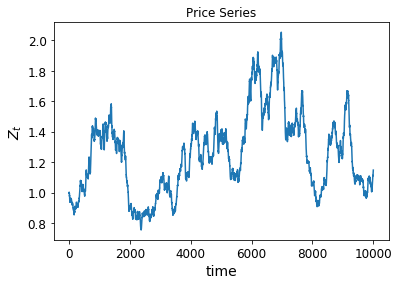

In [3]:
import matplotlib.pyplot as plt

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
# 画出价格曲线
 
plt.plot(z)
plt.title('Price Series')
plt.xlabel('time')
plt.ylabel('$Z_t$')
plt.show()


# RRL Trading System

## Reformuation of RRL using RNN model



![alt text](https://docs.google.com/uc?export=download&id=1bzATrv561I9CND9akmjxCTpwhHk90EDo)


## Preparing Data For the Learning Algorithm


In [0]:
import numpy as np
def constructTimeSeriesWithMultiFeatures(market_info, id_t_start, id_t_end, n_lagged_time_steps ):
    """
    Functionality:
    To construct p-lagged return series X_ts and return series r_ts from price time series 
    market_info from any time period with index ranging from id_t_start to id_t_end
  
    Parameters:
    market_info (numpy): one-dimensional price time series
    id_t_start (int): the index of the starting time
    id_t_end (int): the index of the end time
    n_lagged_time_steps (int): the lagged values
  
    Returns:
    X_ts (numpy): the p-lagged return series
    r_ts (numpy): the return series
    """
    # 用途：从价格数据中创建p阶滞后项(特征集)和下一个回报序列
    price = market_info[id_t_start:id_t_end] # price: 从id_t_start到ending at id_t_end的价格序列
    returnIndex = np.diff(price) # returnIndex:生成回报序列
    # 生成X_ts --回报n_lagged_time_steps 阶滞后项的序列
    X_ts = np.zeros((len(price) - n_lagged_time_steps-1, n_lagged_time_steps)) 
    for i in range(X_ts.shape[0]):
        X_ts[i,:] = returnIndex[np.arange(i, i + n_lagged_time_steps,1)]
    r_ts = returnIndex[n_lagged_time_steps:] 
    return X_ts, r_ts
  
X_ts, r_ts = constructTimeSeriesWithMultiFeatures(z, id_t_start=0,  id_t_end = 10000, n_lagged_time_steps= 8)

In [0]:
from sklearn import preprocessing
r_ts = np.reshape(r_ts, np.shape(r_ts)+(1,))
# 标准化
window_train = 2000
scaler = preprocessing.StandardScaler().fit(X_ts[:window_train])
X_ts = scaler.transform(X_ts)

这里需要注意的是样本量为1. 我们稍后构建的模型将维度为(T, p+1)的输入数据[Xt, rt]映射到维度为[T, p+1]的输出数据. 

## Building a RRL model using Keras 

Let $x_t$ denote the $p$-lagged value of the return, i.e. $x_t  = (r_{t-p+1}, \cdots, r_{t})^{T}$.

1. **Input Layer** (Dark Green):  $(I_{t})_{t = p}^{T-1}$ where $I_{t} = \left( \begin{array}{c}x_{t}\\ r_{t+1}\\ \end{array} \right).$

2. **Hidden Layer** (Pink):  $(Y_{t})_{t = p}^{T-1}$ where  $Y_{t} = \left( \begin{array}{c} F_{t}\\ r_{t+1} \end{array} \right)$.  

  **Step 1**: We split the input layer into two parts: $(x_{t})_{t = p}^{T-1}$ and $(r_{t+1})_{t = p}^{T-1}$.

  **Step 2**: Set up the RNN Layer: $(x_{t})_{t = p}^{T-1} \rightarrow (F_{t})_{t = p}^{T-1}$ .

  **Step 3**: Merge  $(F_{t})_{t = p}^{T-1}$ and $(r_{t+1})_{t = p}^{T-1}$ to $(Y_{t})_{t = p}^{T-1}$. 
  

3. **Output Layer**(Blue):  $(R_{t})_{t = p}^{T-1}$, which can be directly computed from $(Y_{t})_{t = p}^{T-1}$  based on 
\begin{equation*}
R_{t} \equiv u \{ r_{t}^{f} + F_{t-1}(r_{t} - r_{t}^{f}) - \delta \vert F_{t} - F_{t-1} \vert \}.
\end{equation*}
for the given $r_{t}^{f}, \mu$ and $\delta$, as $Y_{t} = (F_{t}, r_{t+1})^{T}$.

4. **Loss Function**: 
\begin{eqnarray*}
S_{T} = \frac{\text{Average}(R_{t})}{\text{Standard Deviation}(R_{t})}
\end{eqnarray*}

![alt text](https://docs.google.com/uc?export=download&id=1xkEIBNrwNxiYd06Khr819i96YnAvT2H-)

In [0]:
import keras
import keras.backend as K
import tensorflow as tf


# define lambda function to split
# split_func1(x)
# output: the time series of p-lagged values
def split_func1(x):    
    p = x._keras_shape
    split1, split2 = tf.split(x, [p[-1]-1, 1], -1)
    return split1

# define lambda function to split
# output: the time series of the next return
def split_func2(x):  
    p = x._keras_shape
    split1, split2 = tf.split(x,  [p[-1]-1, 1], -1)
    return split2
  
def TradingReturn(x, delta):
    F_t_Layer, r_tplus1_Layer = tf.split(x, [1, 1], -1)
    p = x._keras_shape
    F_tminus1_layer1, f1 = tf.split(F_t_Layer, [p[-2]-1, 1], -2)
    f1, F_t_layer1 = tf.split(F_t_Layer, [1, p[-2]- 1], -2)
    transaction_part = delta*tf.abs(tf.subtract(F_t_layer1, F_tminus1_layer1))
    f1= tf.zeros(tf.shape(f1), dtype = float )
    transaction_part = tf.concat([f1, transaction_part], -2)
    output_layer  =  Multiply()([F_t_Layer, r_tplus1_Layer]) -transaction_part
    return output_layer
  
def SharpeRatioLoss(yTrue,yPred):
  B = K.mean(K.square(yPred))
  A = K.mean(yPred)
  return -A/((B-A**2)**0.5) 
  
  


In [0]:
# 加载需要的keras库的模块
from keras.engine.topology import Layer
from keras import optimizers
from keras.layers import SimpleRNN, Dot, Dense, Activation, Input, Lambda, Add, Flatten,Multiply, Concatenate, Subtract
from keras.models import Model, Sequential


def RRL_Model(input_dim, delta):  
  """
  functionality: constract the RRL model with the input layer ([X_ts, r_ts]), the output layer (the trading return) and the loss function(negative shapiro ratio)  
  
  parameters: 
  input_dim: input dimension (1, p, T-p) 
  delta(float): transaction rate
  
  returns:
  model(keras model): the RRL model 
  """
  # 用途：构建输出层代表交易回报序列， 损失函数是交易策略的负夏普比率的神经网络
  model = Sequential()# 初始化model
  input_layer = Input(shape= input_dim)# 初始化输入层张量(形状是输入维度)
  # 步骤一: 将输入层分成两部分 X_t_layer和r_tplus1_layer
  X_t_layer = Lambda(split_func1)(input_layer)
  r_tplus1_Layer = Lambda(split_func2)(input_layer)   
  # 步骤二: 使用SimpleRNN()将X_t_layer映射到F_t_layer
  F_t_Layer = SimpleRNN(1, input_shape=X_t_layer._keras_shape[-2:],activation = 'tanh', return_sequences = True, use_bias=True)(X_t_layer) # 
  # 步骤三: 拼接F_t_Layer和r_tplus1_Layer
  hidden_layer =  Concatenate()([F_t_Layer, r_tplus1_Layer])
  # 将隐藏层映射到代表交易回报序列的输出层
  output_layer  = Lambda(TradingReturn, arguments={'delta':delta})(hidden_layer )
  # 设置model的输入层和输出层分别为input_layer和output_layer
  model = Model(inputs=input_layer, outputs=output_layer)
  sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True) # 设置SGD的参数
  # 设置自定义的SharpeRatioLoss()损失函数，设置SGD为优化方法
  model.compile(loss=SharpeRatioLoss, optimizer=sgd)  
  return model

## Training Process

In [11]:
def ReshapeInput(X_ts, r_ts): 
    # 输入: X_ts - 回报p阶滞后项的序列 [T, p]
    #       r_ts - 下一步的回报序列 [T, 1]
    # 输出: 维度变为[1, nTimeSteps, nFeatures], nTimeSteps = T, nFeatures = p+1 的[X_ts, r_ts]
    X = np.concatenate([X_ts, r_ts], axis = 1)
    X= np.reshape(X, (1,)+np.shape(X))
    return X
  
# 准备数据集，使得其维度和RRL模型匹配
trainX =ReshapeInput(X_ts[:window_train], r_ts[:window_train]) 
testX =ReshapeInput(X_ts[window_train:], r_ts[window_train:]) 
# 建立RRL 模型
model = RRL_Model(np.shape(trainX)[1:], delta= 0.002)
print(model.summary()) #输出模型总结 
model.fit(trainX[:window_train], trainX[:window_train], epochs=100,  verbose=2) # 学习模型参数

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 2000, 9)      0                                            
__________________________________________________________________________________________________
lambda_4 (Lambda)               (None, 2000, 8)      0           input_2[0][0]                    
__________________________________________________________________________________________________
simple_rnn_2 (SimpleRNN)        (None, 2000, 1)      10          lambda_4[0][0]                   
__________________________________________________________________________________________________
lambda_5 (Lambda)               (None, 2000, 1)      0           input_2[0][0]                    
__________________________________________________________________________________________________
concatenat

In [0]:
weights = model.get_weights()#得到模型参数
print('The coefficients of p-lagged values: {}'.format(weights[0]))
print('The coefficients of the previous F(t-1): {}'.format(weights[1]))
print('The bias: {}'.format(weights[2]))

The coefficients of p-lagged values: [[0.63106126]
 [0.46735495]
 [0.14321266]
 [0.3005986 ]
 [0.8071516 ]
 [0.6959603 ]
 [0.72347975]
 [0.35152057]]
The coefficients of the previous F(t-1): [[1.7420658]]
The bias: [0.8193692]


##Testing Process

Given $\theta$ and $F_{0} =0$, at each time $t$, we can evaluate the trading Strategy $F_{t}$:
\begin{eqnarray*}
F_{t} = \text{sign}\left({\color{blue}\mu} F_{t-1} + \sum_{ i = 0}^{p-1} {\color{blue}\nu_{i}} r_{t - i} + {\color{blue}\omega}\right),
\end{eqnarray*}
where $F_{t} \in \{ -1, 0, +1\}$, and ${\color{blue}\theta \equiv (\mu,\nu_{0} \cdots, \nu_{m}, \omega)}$ are model parameters.

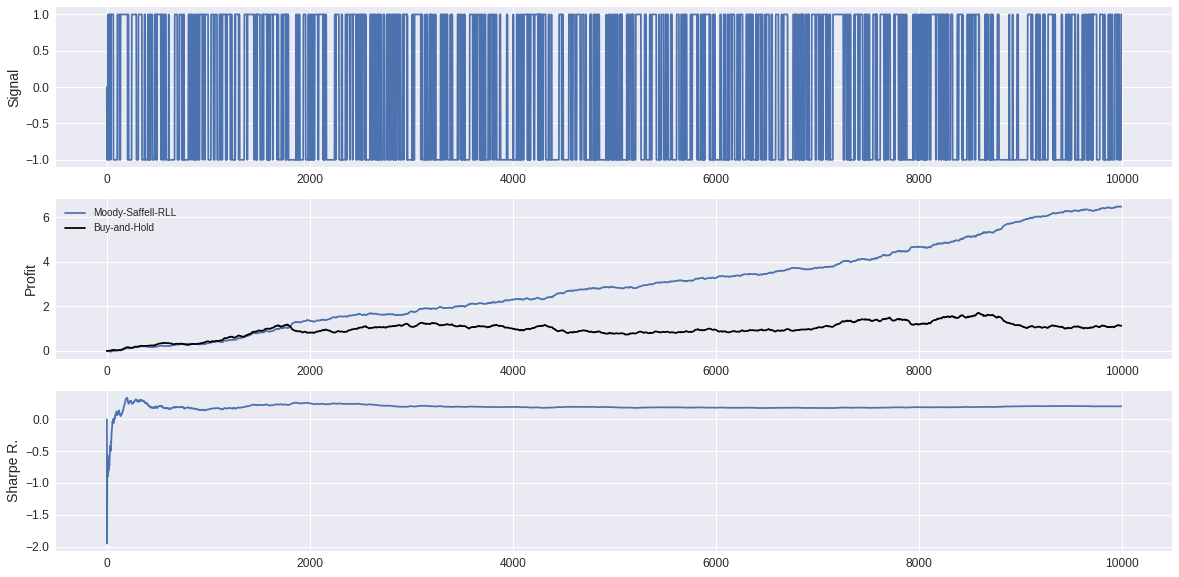

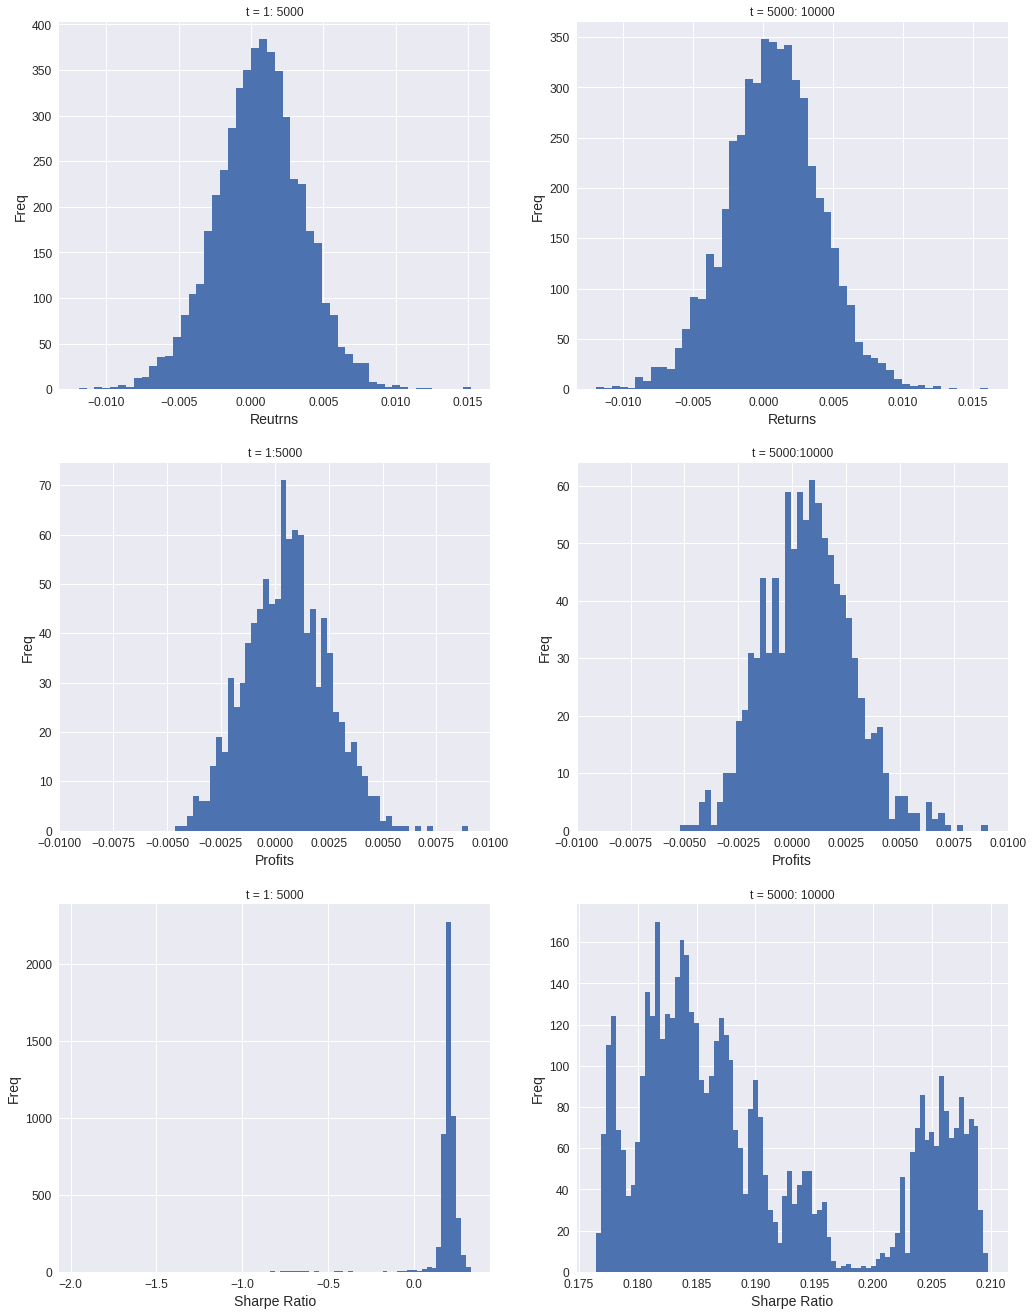

In [0]:
from numpy import divide, power 

def NextWindow(weights, X_t, F_t):
  weights = weights.reshape(np.shape(X_t))   
  F_tplus1 = np.sign(np.dot(weights, X_t)+weights[1]*F_t + weights[2])
  return F_tplus1

def Prediction(X, model, delta):
  weights = model.get_weights()[0] 
  F = np.zeros(np.shape(X)[1], dtype = float)  
  R = np.zeros(np.shape(X)[1], dtype = float)  
  l = np.shape(F)[0]
  for i in range(l-1):  
    F[i+1] = NextWindow(weights, X[0, i, :-1], F[i])
    R[i+1] = F[i+1]*X[0, i, -1]-delta*(np.abs(F[i+1] - F[i]))

  A = np.zeros(np.shape(F))
  B = np.zeros(np.shape(F))
  D = np.zeros(np.shape(F))
  var_R = np.zeros(np.shape(F))
  A[1:] = divide(np.cumsum(R)[1:], np.arange(l)[1:])
  B[1:] = np.divide(np.cumsum(np.power(R, 2))[1:], np.arange(l)[1:])
  var_R[2:] = B[2:]- power(A, 2)[2:]
  D[2:] =  A[2:]/ np.sqrt(var_R[2:])
  return F, R, D
                     
def Plot_Price_F_Profit_SharpeR(r, F, R, D):
  plt.subplots(3, 1, figsize=( 20, 10))
  plt.subplot(3,1, 1)
  plt.plot(F)
  plt.ylabel('Signal')
  plt.subplot(3,1, 2)
  plt.plot(np.cumsum(R), label="Moody-Saffell-RLL")
  plt.plot(np.cumsum(r), color='black',label="Buy-and-Hold")
  plt.ylabel('Profit')
  plt.legend(loc="upper left")
  plt.subplot(3,1, 3)
  plt.plot(D)
  plt.ylabel('Sharpe R.')
  plt.legend(loc="upper left")

  
def PlotAverageWeeklyReturn( R ):
    l = np.int(np.floor(np.shape(R)[0]/5))
    avgProfit = R[: l*5].reshape(l, 5)
    avgProfit = np.mean(avgProfit, 1)
    plt.hist(avgProfit, bins=50)
    plt.xlim((-0.01, 0.01))  
    
def Plot_Hist_R_SharpR(R, D): 
  plt.subplots(3,2,figsize=( 17, 23))
  plt.subplot(3, 2, 1)
  plt.hist(R[:5000], 50)
  plt.xlabel('Reutrns')
  plt.ylabel('Freq')
  plt.title('t = 1: 5000')
  plt.subplot(3, 2, 2)
  plt.hist(R[5000:], 50)
  plt.xlabel('Returns')
  plt.ylabel('Freq')
  plt.title('t = 5000: 10000') 
  plt.subplot(3, 2, 3)
  PlotAverageWeeklyReturn( R[:5000] )
  plt.xlabel('Profits')
  plt.ylabel('Freq')
  plt.title('t = 1:5000')
  plt.subplot(3, 2, 4)  
  PlotAverageWeeklyReturn( R[5000:] )
  plt.xlabel('Profits')
  plt.ylabel('Freq')
  plt.title('t = 5000:10000')
  plt.subplot(3, 2, 5)
  plt.hist(D[:5000], 80)
  plt.xlabel('Sharpe Ratio')
  plt.ylabel('Freq')
  plt.title('t = 1: 5000')
  plt.subplot(3, 2, 6)
  plt.hist(D[5000:], 80)
  plt.xlabel('Sharpe Ratio')
  plt.ylabel('Freq')
  plt.title('t = 5000: 10000')
  plt.show()
  
X =ReshapeInput(X_ts, r_ts)   
F, R, D = Prediction(X, model, delta)
Plot_Price_F_Profit_SharpeR(r_ts, F, R, D)
Plot_Hist_R_SharpR(R, D)



# Future Work



1.  Synthetic Data:

      (1)  When the transaction cost parameter $\delta$ is large, the above algorithm is not stable; 
      
      (2)  Consider the differential Sharpe Ratio as the utility function to further improve the efficiency of the algorithm.
      
2.  Empirical Data: How to choose the external variables?

3. Other methods to derive the optmial trading strategy?

